In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

import cv2
import matplotlib.pyplot as plt
from modules.inference.object_detection import Model
import numpy as np

In [2]:
def load_image_and_annotations(logistics_folder):
    data = []

    for filename in os.listdir(logistics_folder):
        if filename.endswith('.jpg'):
            image_path = os.path.join(logistics_folder, filename)
            annotation_path = os.path.join(logistics_folder, filename.replace('.jpg', '.txt'))

            image = cv2.imread(image_path)
            
            if os.path.exists(annotation_path):
                annotations = []
                
                with open(annotation_path, 'r') as file:
                    for line in file:
                        annotation = line.strip().split()
                        class_id = int(annotation[0])
                        x_center = float(annotation[1])
                        y_center = float(annotation[2])
                        width = float(annotation[3])
                        height = float(annotation[4])
                        
                        annotations.append([class_id, x_center, y_center, width, height])

                data.append((image, annotations))
    
    return data

logistics_folder = '../datasets/logistics'
data = load_image_and_annotations(logistics_folder)

In [3]:
def to_corners(bbox):
    x_center, y_center, bbox_width, bbox_height = bbox
    x_min = x_center - bbox_width / 2
    y_min = y_center - bbox_height / 2
    x_max = x_center + bbox_width / 2
    y_max = y_center + bbox_height / 2
    return x_min, y_min, x_max, y_max

def compute_iou(pred_bbox, gt_bbox, img_shape):

    height, width = img_shape[:2]
    pred_bbox_normalized = [
        pred_bbox[0] / width, 
        pred_bbox[1] / height,
        pred_bbox[2] / width, 
        pred_bbox[3] / height
    ]

    pred_xmin, pred_ymin, pred_xmax, pred_ymax = to_corners(pred_bbox_normalized)
    gt_xmin, gt_ymin, gt_xmax, gt_ymax = to_corners(gt_bbox)
    
    x_inter_min = max(pred_xmin, gt_xmin)
    y_inter_min = max(pred_ymin, gt_ymin)
    x_inter_max = min(pred_xmax, gt_xmax)
    y_inter_max = min(pred_ymax, gt_ymax)

    inter_area = max(0, x_inter_max - x_inter_min) * max(0, y_inter_max - y_inter_min)

    pred_area = (pred_xmax - pred_xmin) * (pred_ymax - pred_ymin)
    gt_area = (gt_xmax - gt_xmin) * (gt_ymax - gt_ymin)

    union_area = pred_area + gt_area - inter_area

    iou = inter_area / union_area if union_area != 0 else 0

    return iou

In [4]:
def calculate_losses(images_and_annotations, model):
    losses = []

    for image, annotations in images_and_annotations:
        predictions = model.predict(image)
        processed_predictions = model.post_process(image, predictions, score_threshold=0.5)

        image_loss = 0
        num_boxes = min(len(processed_predictions[0]), len(annotations))

        for i in range(num_boxes):
            pred_bbox = processed_predictions[0][i]
            ann_bbox = annotations[i][1:]

            iou = compute_iou(pred_bbox, ann_bbox, img_shape=image.shape)
            loss = 1 - iou
            image_loss += loss

        if num_boxes > 0:
            image_loss /= num_boxes
        losses.append(image_loss)

    return losses

In [5]:
model = Model(weights_path='../datasets/yolo_model_2/yolov4-tiny-logistics_size_416_2.weights', 
              config_path='../datasets/yolo_model_2/yolov4-tiny-logistics_size_416_2.cfg', 
              class_names_path='../datasets/yolo_model_1/logistics.names')

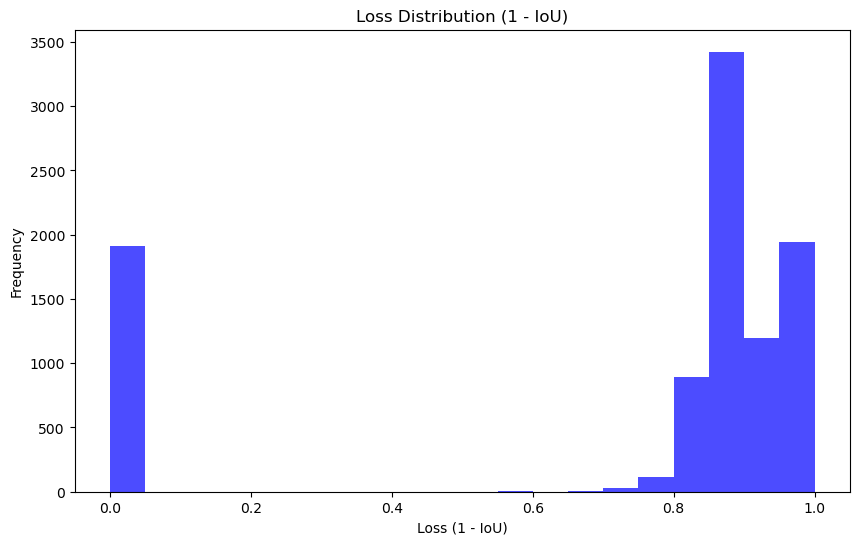

In [6]:
losses = calculate_losses(data, model)

plt.figure(figsize=(10, 6))
plt.hist(losses, bins=20, color='blue', alpha=0.7)
plt.title('Loss Distribution (1 - IoU)')
plt.xlabel('Loss (1 - IoU)')
plt.ylabel('Frequency')
plt.show()

The loss distribution graph shows a clear distinction between easy and hard samples for the model. On one hand, a significant number of samples show loss = 0, which means the model perfectly predicts the bounding boxes for these images (IoU = 1). On the other hand, a large number of samples have a loss close to 1 (IoU ≈ 0), indicating the model struggles significantly with these predictions.

### Hard Samples for the Model:
The samples where the model performs poorly (high loss) tend to exhibit characteristics that make object detection difficult:

 - Occlusions: When objects are partially obscured by other objects or elements in the scene, the model may misidentify or miss them entirely, leading to bounding boxes that poorly overlap with the ground truth.
- Complex Backgrounds: If the object blends into a background with significant visual noise or clutter, the model might struggle to separate the object from the background, resulting in inaccurate bounding boxes.
- Small Objects: For smaller objects in an image, even minor inaccuracies in the predicted bounding box can significantly reduce IoU. The model may miss these objects entirely or predict bounding boxes that do not accurately localize them.
- Edge Cases: Objects that appear at the edges or corners of the image may be partially cropped, making them harder to detect or localize, which results in poor predictions.

These hard samples indicate that the model struggles to generalize to complex or challenging scenarios where object boundaries are not clear or the object is less prominent.

### Parameters Impacting Model Behavior:
The performance of the model and the distribution of the loss are heavily influenced by certain parameters:

- Confidence Threshold: The threshold used to filter predictions based on confidence scores significantly impacts the results. A lower threshold may include more false positives (incorrect or low-confidence predictions), increasing the number of high-loss samples. On the other hand, a higher threshold may eliminate lower-confidence predictions but also reduce recall by filtering out valid, albeit uncertain, predictions.
- IoU Threshold for Non-Maximum Suppression (NMS): This threshold controls how overlapping bounding boxes are handled. A lower NMS threshold might suppress too many boxes, leading to fewer predictions but also causing the model to miss overlapping objects. A higher threshold could allow too many boxes for the same object, decreasing the overall IoU for some samples.
- Object Size: Larger objects tend to be easier to detect, and small misalignments in bounding boxes result in smaller IoU drops. However, for smaller objects, even a slight deviation in the predicted bounding box can lead to a significant drop in IoU, which makes these samples particularly challenging.
- Model Training and Augmentation: The robustness of the model depends on how well it has been trained across diverse scenarios. If the model was trained primarily on well-lit or large objects, it may perform poorly on smaller objects, occlusions, or more complex scenarios. Similarly, a lack of adequate data augmentation during training (such as varying lighting conditions, object sizes, or rotations) can make the model less adaptable to real-world variations, leading to higher losses on test images.